# Training of some Classifiers

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from nltk.tokenize import word_tokenize
from typing import *
from sklearn import preprocessing

In [2]:
sys.path.append("../")
from rs_helper import DAN, FastTextWrapper, read_data, Batches, confusion_matrix_plot, scatter_plot

c:\users\daniel\anaconda3\envs\rs\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Read Data

In [3]:
data = "../datasets/final_datasets/clean_equal_augmented" 
data_valid = "../datasets/eval_data"

In [4]:
df = read_data(data).sample(frac = 1)

In [5]:
df.head()

,url,text,class
6161,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,follow the choice of bandwidth type of kernel ...,clustering
18457,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,therefore the most important issuing in lend o...,prediction
12017,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,in the project management field unsupervised d...,pattern_mining
6348,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,introduction the determination of bundle is to...,clustering
19204,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,they called this process class energizing map ...,prediction


In [6]:
df_valid = read_data(data_valid)

In [7]:
df_valid.head()

,url,text,class
0,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,I want to group my machines according to their...,clustering
1,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,Identifying groups of motor insurance policy h...,clustering
2,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,I want to identify workout sessions that are s...,clustering
3,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,I want to extract a set of colours from an ima...,clustering
4,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,As a grocery store we want to group our 1.3MM ...,clustering


## Add Embeddings

In [8]:
ft_model = FastTextWrapper("ft_models/fasttext_12/model.joblib")

INFO:tensorflow:FastText Model is loading
INFO:tensorflow:FastText Model loaded!


In [9]:
dan = DAN(ft_model, "../models/DANs/1/frozen_graph.pb")

In [10]:
%%time
df["tokenized"] = df["text"].apply(lambda x: word_tokenize(x))
df["embedding"] = dan.inference_batches(df["tokenized"].tolist())
df["embedding"] = df["embedding"].apply(lambda x: x[0])

Wall time: 25.2 s


In [11]:
df_valid["tokenized"] = df_valid["text"].apply(lambda x: word_tokenize(x))
df_valid["embedding"] = dan.inference_batches(df_valid["tokenized"].tolist())
df_valid["embedding"] = df_valid["embedding"].apply(lambda x: x[0])

## Add One Hot Encodings

In [12]:
def get_one_hot_encodings(labels):
    le = preprocessing.LabelEncoder()
    labels.apply(le.fit_transform)
    enc = preprocessing.OneHotEncoder()
    enc.fit(labels)
    return enc.transform(labels).toarray()

In [13]:
one_hot_encodings = get_one_hot_encodings(df.drop(columns = ["url", "text", "embedding", "tokenized"]))
valid_one_hot_encodings = get_one_hot_encodings(df_valid.drop(columns = ["url", "text", "tokenized", "embedding"]))

## Visualizing Data

[0.66082189 0.96741376]
[0.65986532 0.90375147]


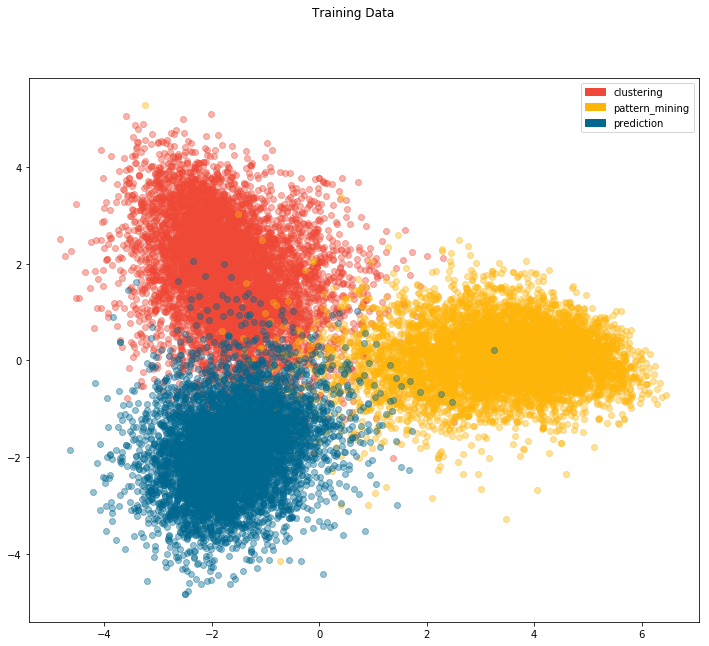

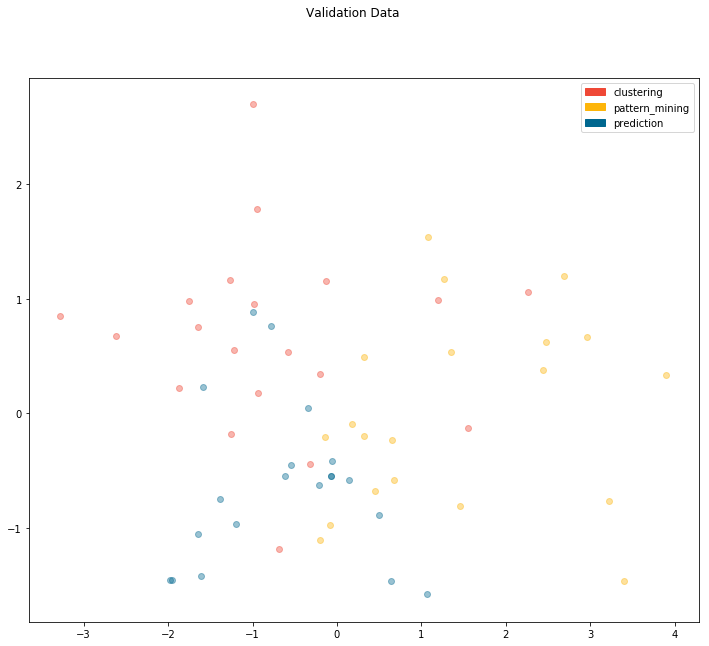

In [14]:
ax_1 = scatter_plot(dan, df["text"].tolist(), df["class"].tolist(), fig_title = "Training Data")
ax_2 = scatter_plot(dan, df_valid["text"].tolist(), df_valid["class"].tolist(), fig_title = "Validation Data")

## Multilayer Perceptron
--> Implement Penalties
--> Implement Dropout
--> Implement Batch Regularization

In [15]:
tf.reset_default_graph()

In [16]:
x_input = tf.placeholder(dtype = tf.float32, shape = (None, 100), name = "placeholder_input")

In [17]:
y_true = tf.placeholder(dtype = tf.float32, shape = (None, 3), name = "placeholder_y_true")

In [18]:
def classifier_layers(input_layer, classifier_shape: List[int], classifier_act):
    c_layers = []
    for i, neurons in enumerate(classifier_shape):
        if i == 0:
            dense_layer = tf.layers.dense(inputs=input_layer,
                                          units=neurons,
                                          activation=classifier_act,
                                          use_bias=True,
                                          trainable=True,
                                          name="cl_layer_{}".format(i))
            c_layers.append(dense_layer)
        else:
            dense_layer = tf.layers.dense(inputs=c_layers[-1],
                                          units=neurons,
                                          activation=classifier_act,
                                          use_bias=True,
                                          trainable=True,
                                          name="cl_layer_{}".format(i))
            c_layers.append(dense_layer)
    return c_layers

In [19]:
hidden_layer_1 = tf.layers.dense(inputs=x_input,units=22,activation=tf.nn.tanh,use_bias=True,trainable=True,name="hidden_layer_1")

In [20]:
dropout_layer_1 = tf.layers.dropout(inputs = hidden_layer_1, rate = 0.6, training = True,  name = "dropout_layer_1")

In [21]:
hidden_layer_2 = tf.layers.dense(inputs=hidden_layer_1,units=22,activation=tf.nn.tanh,use_bias=True,trainable=True,name="hidden_layer_2")

In [22]:
#hidden_layer = classifier_layers(x_input, [34], tf.nn.leaky_relu)

In [23]:
logits = tf.layers.dense(inputs=hidden_layer_2,units=3,activation=None,use_bias=True,trainable=True,name="logits")

In [24]:
with tf.name_scope("loss"):
    softmax_layer = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits = logits, name = "softmax_layer")
    cross_entropy = tf.reduce_mean(softmax_layer)
    tf.summary.scalar("cross_entropy", cross_entropy)

In [25]:
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train = optimizer.minimize(cross_entropy, name="train")

In [26]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # https://www.tensorflow.org/guide/using_gpu#allowing_gpu_memory_growth

In [27]:
epoches = 10
batch_size = 256

In [28]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    # merged_summary = tf.summary.merge_all()
    #writer = tf.summary.FileWriter(save_path)
    #writer.add_graph(sess.graph)

    for i in range(epoches):
        batches = Batches(x=df["embedding"].tolist(), y=one_hot_encodings, batch_size=batch_size)
        
        for j,batch in enumerate(batches):
            X = batch[0]
            Y = batch[1]
            
            
            _, loss, _logits = sess.run([train, cross_entropy, logits], feed_dict={x_input: np.stack(X), y_true: np.stack(Y)})
            valid_logits = sess.run(logits, feed_dict={x_input: np.stack(df_valid["embedding"].values), y_true: np.stack(valid_one_hot_encodings)})
            
            probs = sess.run(tf.nn.softmax(_logits))
            probs_valid = sess.run(tf.nn.softmax(valid_logits))
            
            y_pred_valid = np.argmax(probs_valid, axis = 1)
            _y_true_valid = np.asarray([np.argmax(x) for x in valid_one_hot_encodings])
            
            y_pred = np.argmax(probs, axis = 1)
            _y_true = [np.argmax(x) for x in Y]
        
            insampling_accuracy = (y_pred == _y_true).sum() / len(_y_true) 
            valid_accuracy = (y_pred_valid == _y_true_valid).sum() / len(_y_true_valid)
           
            #print(loss)
            #print(insampling_accuracy)
            if valid_accuracy >= 0.7:
                print("Thats some shit!")
                print(i)
                print(loss)
                print(insampling_accuracy)
                print(valid_accuracy)
                print("______________")
        #print("Thats some real shit!")
        print(i)
        print(loss)
        print(insampling_accuracy)
        print(valid_accuracy)
        print("______________")
        
        
        

    #saver.save(sess, os.path.join("testRUN", "test_1" + ".ckpt"))

0
0.5438792
0.9398907103825137
0.5833333333333334
______________
1
0.43315956
0.9289617486338798
0.65
______________
2
0.25835732
0.9726775956284153
0.6333333333333333
______________
3
0.22125359
0.9672131147540983
0.6333333333333333
______________
4
0.2308354
0.9562841530054644
0.65
______________
5
0.20342699
0.9562841530054644
0.65
______________
6
0.17058077
0.9508196721311475
0.65
______________
7
0.16943935
0.9508196721311475
0.65
______________
8
0.14456558
0.9781420765027322
0.65
______________
9
0.15722492
0.9562841530054644
0.65
______________


## Support Vector Machine

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import multiprocessing
import itertools

In [30]:
# Do Poly seperatly because of degress --> Would be used for other kernels as well, which is dumb

In [31]:
# parameters = {'kernel':('linear', 'rbf'),'C':range(10,100,2), "gamma": ["auto", "scale"] }
parameters = {'kernel':('linear', 'rbf'),'C':range(75,82,2), "gamma": ["auto", "scale"] }

In [32]:
len(list(itertools.product(parameters["kernel"],parameters["C"] ,parameters["gamma"])))

16

In [33]:
clf = GridSearchCV(SVC(), parameters, cv=5, n_jobs = -1, verbose = 1)

In [34]:
svm_X = df["embedding"].tolist()

In [35]:
svm_Y = [np.argmax(x) for x in one_hot_encodings]

In [36]:
# %%time
clf.fit(svm_X, svm_Y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': range(75, 82, 2), 'gamma': ['auto', 'scale']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
scores_df = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

c:\users\daniel\anaconda3\envs\rs\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\daniel\anaconda3\envs\rs\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\daniel\anaconda3\envs\rs\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\daniel\anaconda3\en

In [38]:
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,10.300669,0.333731,0.922820,0.170464,75,scale,rbf,"{'C': 75, 'gamma': 'scale', 'kernel': 'rbf'}",0.961072,0.955624,...,0.959707,0.002788,1,0.964203,0.963887,0.963436,0.963113,0.963887,0.963705,0.000384
7,10.240844,0.435687,0.868208,0.153015,77,scale,rbf,"{'C': 77, 'gamma': 'scale', 'kernel': 'rbf'}",0.961072,0.955624,...,0.959655,0.002722,2,0.964267,0.963887,0.963371,0.963113,0.964016,0.963731,0.000425
11,9.823301,0.410621,0.945344,0.162033,79,scale,rbf,"{'C': 79, 'gamma': 'scale', 'kernel': 'rbf'}",0.961072,0.955366,...,0.959655,0.002827,2,0.964332,0.964016,0.963436,0.963242,0.964016,0.963809,0.000405
15,8.846373,0.580165,0.650805,0.129659,81,scale,rbf,"{'C': 81, 'gamma': 'scale', 'kernel': 'rbf'}",0.961330,0.955366,...,0.959604,0.002804,4,0.964396,0.964210,0.963500,0.963500,0.964081,0.963937,0.000371
0,15.823640,2.111310,0.680521,0.058439,75,auto,linear,"{'C': 75, 'gamma': 'auto', 'kernel': 'linear'}",0.959783,0.955882,...,0.959036,0.002062,5,0.963300,0.964274,0.962469,0.962855,0.962662,0.963112,0.000643


In [39]:
svc_pred = clf.predict(df_valid["embedding"].tolist())

In [40]:
svc_true = [np.argmax(x) for x in valid_one_hot_encodings]

In [41]:
(svc_pred == svc_true).sum()/len(svc_true)

0.7833333333333333

## K-Nearest Neigboor

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
k_nearest = KNeighborsClassifier(n_neighbors=3,  n_jobs = -1)

In [44]:
k_nearest.fit(svm_X, svm_Y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [45]:
k_pred = k_nearest.predict(df_valid["embedding"].tolist())

In [46]:
(k_pred == svc_true).sum()/len(svc_true)

0.7166666666666667

In [47]:
k_nearest

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

## Evaluation

### Heatmaps

In [48]:
labels = ["clustering", "pattern_mining", "prediction"]

#### MLP
TODO

#### SVM

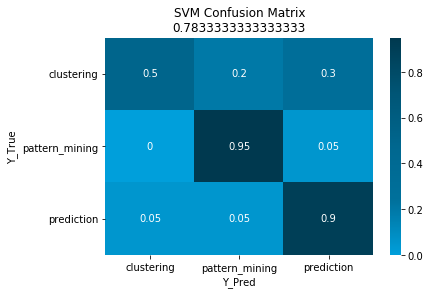

In [51]:
confusion_matrix_plot(svc_true, svc_pred, "SVM Confusion Matrix", labels, True)

#### K-Nearest Neighboor

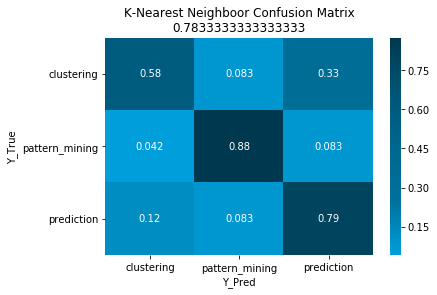

In [52]:
confusion_matrix_plot(k_pred, svc_pred,"K-Nearest Neighboor Confusion Matrix" ,labels, True)